In [1]:
# Import all the necessary libraries
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Do not print warnings
warnings.filterwarnings('ignore')


### 1. site effects dataset


In [2]:
site_effect = pd.read_csv('site-effects.txt', sep='\s+',
                          error_bad_lines=False, index_col=False, dtype='unicode')
site_effect


,HugoSymbol,Location,InteractionType,Status
0,BCR/ABL fusion,Y177,PHOSPHORYLATION,1
1,AANAT,T31,PHOSPHORYLATION,0
2,AATF,S143,PHOSPHORYLATION,1
3,AATF,S189,PHOSPHORYLATION,1
4,AATF,S477,PHOSPHORYLATION,1
...,...,...,...,...
10585,ZRANB1,T35,PHOSPHORYLATION,1
10586,ZWINT,S250,PHOSPHORYLATION,0
10587,ZWINT,S262,PHOSPHORYLATION,0
10588,ZWINT,T251,PHOSPHORYLATION,0


In [3]:
site_effect['InteractionType'].value_counts()


PHOSPHORYLATION    9682
ACETYLATION         648
METHYLATION         148
UBIQUITINATION      112
Name: InteractionType, dtype: int64

In [4]:
site_effect['Location'].value_counts().head(25)


S12     25
S19     22
S20     21
S21     21
S36     21
S14     19
S83     19
S27     18
S44     17
S7      17
S13     17
S11     17
S181    17
S18     16
S28     16
S88     16
S293    16
S96     16
S183    16
S8      16
S15     16
S184    15
S65     15
S39     15
S215    15
Name: Location, dtype: int64

In [5]:
# There are three types of Status in Site Effects
#  1 -> activating site
# -1 -> in-activating site
#  0 -> complex un-decided

# Ignoring all the genes which has complex Site effect in on site

site_effect = site_effect[site_effect['Status'] != '0']
site_effect.reset_index(drop=True, inplace=True)
site_effect

,HugoSymbol,Location,InteractionType,Status
0,BCR/ABL fusion,Y177,PHOSPHORYLATION,1
1,AATF,S143,PHOSPHORYLATION,1
2,AATF,S189,PHOSPHORYLATION,1
3,AATF,S477,PHOSPHORYLATION,1
4,AATF,S510,PHOSPHORYLATION,1
...,...,...,...,...
6050,ZRANB1,S209,PHOSPHORYLATION,1
6051,ZRANB1,S78,PHOSPHORYLATION,1
6052,ZRANB1,T117,PHOSPHORYLATION,1
6053,ZRANB1,T35,PHOSPHORYLATION,1


In [6]:
site_effect.to_csv("data/SiteEffects.csv", index=False)


---


### 2. OncoKB Cancer Gene List


In [7]:
onco_KB = pd.read_csv('OncoKB-CancerGeneList.tsv', sep='\s+',
                      error_bad_lines=False, index_col=False, dtype='unicode')
onco_KB


,HugoSymbol,EntrezGeneID,Isoform,RefSeq,#ofOccurrenceWithinResources(Column-D-J),OncoKBAnnotated,IsOncogene,IsTumorSuppressorGene,MSK-IMPACT,MSK-HEME,FOUNDATIONONE,FOUNDATION-ONE-HEME,Vogelstein,SANGERCGC(05/30/2017)
0,LYL1,4066,2,No,No,No,No,No,No,Yes,No,Yes,NaN,NaN
1,LYN,4067,ENST00000519728,NM_002350.3,4,Yes,Yes,No,Yes,Yes,Yes,No,No,No
2,SH2D1A,4068,ENST00000371139,NM_002351.4,3,Yes,No,Yes,Yes,Yes,No,No,No,No
3,OLIG2,10215,1,No,No,No,No,No,No,No,No,Yes,NaN,NaN
4,EPCAM,4072,ENST00000263735,NM_002354.2,3,Yes,No,Yes,Yes,Yes,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,GREM1,26585,ENST00000300177,NM_013372.6,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1055,EGFL7,51162,ENST00000308874,NM_201446.2,3,Yes,Yes,No,Yes,Yes,No,No,No,No
1056,LTK,4058,1,No,No,No,No,No,Yes,No,No,No,NaN,NaN
1057,SPRTN,83932,ENST00000295050,NM_032018.6,2,Yes,No,Yes,Yes,No,No,No,No,No


#### Remove unnecessary columns except IsOncogene and IsTumorSupressorGene


In [8]:
onco_KB = onco_KB[['HugoSymbol', 'IsOncogene', 'IsTumorSuppressorGene']]
onco_KB


,HugoSymbol,IsOncogene,IsTumorSuppressorGene
0,LYL1,No,No
1,LYN,Yes,No
2,SH2D1A,No,Yes
3,OLIG2,No,No
4,EPCAM,No,Yes
...,...,...,...
1054,GREM1,Yes,No
1055,EGFL7,Yes,No
1056,LTK,No,No
1057,SPRTN,No,Yes


In [9]:
# Export to csv
onco_KB.to_csv('data/OncoKBCancerGeneList.csv', index=False)


#### Print counts of IsOncogene and IsTumorSupressorGene


No     769
Yes    290
Name: IsOncogene, dtype: int64


<AxesSubplot:>

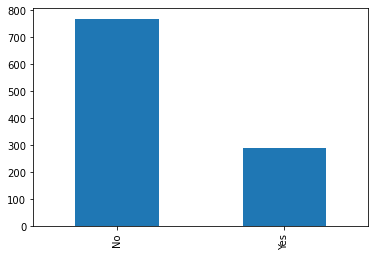

In [10]:
print(onco_KB['IsOncogene'].value_counts())
pd.value_counts(onco_KB['IsOncogene']).plot.bar()


No     758
Yes    301
Name: IsTumorSuppressorGene, dtype: int64


<AxesSubplot:>

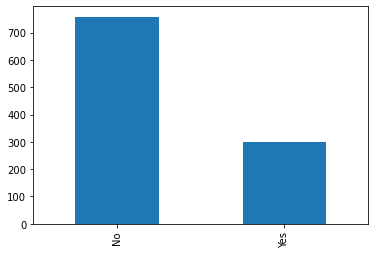

In [11]:
print(onco_KB['IsTumorSuppressorGene'].value_counts())
pd.value_counts(onco_KB['IsTumorSuppressorGene']).plot.bar()


In [12]:
# Genes which are behaving as both tumor supressor and oncogene
both = onco_KB[onco_KB['IsOncogene'] == 'Yes']
both = both[both['IsTumorSuppressorGene'] == 'Yes']

both.shape


(39, 3)

In [13]:
# Genes which are behaving as both tumor supressor and oncogene
bothNot = onco_KB[onco_KB['IsOncogene'] == 'No']
bothNot = bothNot[bothNot['IsTumorSuppressorGene'] == 'No']

bothNot


,HugoSymbol,IsOncogene,IsTumorSuppressorGene
0,LYL1,No,No
3,OLIG2,No,No
5,LEF1,No,No
6,RPL5,No,No
9,HIST2H3C,No,No
...,...,...,...
1051,TAF15,No,No
1052,ELK4,No,No
1053,ELN,No,No
1056,LTK,No,No


#### Plotting values for better insights


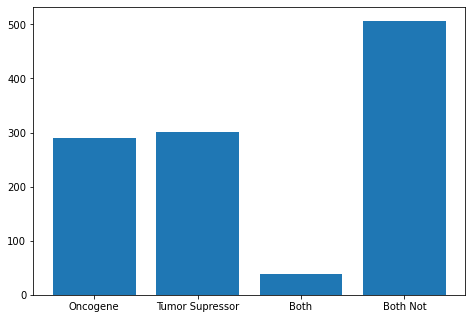

In [14]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
langs = ['Oncogene', 'Tumor Supressor', 'Both', 'Both Not']
values = [onco_KB['IsOncogene'].value_counts()[1], onco_KB['IsTumorSuppressorGene'].value_counts()[
    1], both.shape[0], bothNot.shape[0]]
ax.bar(langs, values)
plt.show()


---


### 3. Causal priors dataset


In [15]:
fields = ['Gene', 'InteractionType', 'Output', 'URL', 'Location']
causal_prior = pd.read_csv('causal-priors.txt', sep='\t', error_bad_lines=False,
                           index_col=False, dtype='unicode', skipinitialspace=True)
causal_prior.columns = fields
causal_prior.head(25)


,Gene,InteractionType,Output,URL,Location
0,SULT1A1,consumes,CHEBI:207496,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
1,INS,phosphorylates,IRS2,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
2,INS,phosphorylates,IRS4,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
3,MAK,upregulates-expression,KLK3,http://pathwaycommons.org/pc12/TemplateReactio...,NaN
4,HDAC4,deacetylates,YWHAE,PMID:19608861,K123;K50;K118
5,INS,phosphorylates,IRS1,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
6,CDIPT,produces,CHEBI:73229,http://pathwaycommons.org/pc12/Catalysis_377b1...,NaN
7,SULT2A1,produces,CHEBI:16325,http://pathwaycommons.org/pc12/Control_c53153b...,NaN
8,TPCN1,dephosphorylates,RHO,http://identifiers.org/reactome/R-HSA-2581474 ...,S338;S334;S343
9,TPCN2,dephosphorylates,RHO,http://identifiers.org/reactome/R-HSA-2581474 ...,S338;S334;S343


#### Removing small chemical compunds CHEBI


In [16]:
causal_pr = causal_prior[~causal_prior["Output"].str.contains("CHEBI")]
causal_pr.reset_index(drop=True, inplace=True)
causal_pr


,Gene,InteractionType,Output,URL,Location
0,INS,phosphorylates,IRS2,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
1,INS,phosphorylates,IRS4,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
2,MAK,upregulates-expression,KLK3,http://pathwaycommons.org/pc12/TemplateReactio...,NaN
3,HDAC4,deacetylates,YWHAE,PMID:19608861,K123;K50;K118
4,INS,phosphorylates,IRS1,http://pathwaycommons.org/pc12/BiochemicalReac...,NaN
...,...,...,...,...,...
45576,LEF1,upregulates-expression,MMP2,http://pathwaycommons.org/pc12/TemplateReactio...,NaN
45577,BAMBI,dephosphorylates,TGFBR3,http://pathwaycommons.org/pc12/ComplexAssembly...,T842
45578,BAMBI,dephosphorylates,TGFBR1,http://pathwaycommons.org/pc12/ComplexAssembly...,T176;S165;S172
45579,ARNT,upregulates-expression,FLT1,http://pathwaycommons.org/pc12/TemplateReactio...,NaN


In [17]:
causal_pr['InteractionType'].value_counts()


phosphorylates              25549
upregulates-expression       8942
dephosphorylates             4648
downregulates-expression     2897
deacetylates                 1210
acetylates                   1020
methylates                    714
demethylates                  329
activates-gtpase              210
inhibits-gtpase                62
Name: InteractionType, dtype: int64

In [18]:
# Deleting URL column from causal priors
causal_pr = causal_pr[['Gene', 'InteractionType', 'Output', 'Location']]
causal_pr


,Gene,InteractionType,Output,Location
0,INS,phosphorylates,IRS2,NaN
1,INS,phosphorylates,IRS4,NaN
2,MAK,upregulates-expression,KLK3,NaN
3,HDAC4,deacetylates,YWHAE,K123;K50;K118
4,INS,phosphorylates,IRS1,NaN
...,...,...,...,...
45576,LEF1,upregulates-expression,MMP2,NaN
45577,BAMBI,dephosphorylates,TGFBR3,T842
45578,BAMBI,dephosphorylates,TGFBR1,T176;S165;S172
45579,ARNT,upregulates-expression,FLT1,NaN


In [19]:
# Counting NaN location values in causal priors
causal_pr['Location'].isna().sum()


23988

In [20]:
causal_pr['Location'].value_counts().head(25)


S15                                      276
Y172                                     217
Y173                                     217
Y174                                     206
S602;T599                                185
Y783;Y771;Y1253;Y472                     137
Y90                                      126
T183                                     118
T172                                     118
S14                                      114
S568                                     109
S338;S334;S343                           106
S1127;S1107;S1084;S1089                  106
Y185;T183                                102
S196                                     101
T180;Y182                                 99
Y145;Y113;Y128                            99
T182;Y184                                 90
Y203;T201                                 88
Y323;Y525;Y348;Y526;Y352;Y131             85
S338;S494;T491;Y341                       84
S657                                      82
T634;T499;

In [21]:
# Remove all the rows which does not have site locations
causal_pr = causal_pr[causal_pr['Location'].notna()]
causal_pr.reset_index(drop=True, inplace=True)


In [22]:
causal_pr.to_csv("data/CausalPriorFiltered.csv", index=False)

In [23]:
# RB1 is a tumor suppressor
# sign(RB1) is -1
# P-site in inactivating
# sign(p-site) = -1
# Relation = phosphorylation
# sign(relation) = 1
# -1 * -1 * 1 = 1


### Function to Return whether a gene is Tumor Suppressor or Oncogene


In [24]:
def getGeneType(geneName):
    ''' This function returns -1 -> Tumor Supressor Gene
                               1 -> Oncogene
                               0 -> For Both
                               -2 -> For Not Both
                               -3 -> For Unknown
    '''
    geneStatus = pd.read_csv('data/OncoKBCancerGeneList.csv')
    # for index, row in geneStatus.iterrows():
    #     if(geneName == str(row['HugoSymbol'])):

    a = geneStatus.loc[(geneStatus['HugoSymbol']) == (geneName)]

    if(a.empty):
        return -3

    isOncogene = (a['IsOncogene']).iloc[0]
    isTumorSupressor = (a['IsTumorSuppressorGene']).iloc[0]

    if(isOncogene == 'No' and isTumorSupressor == 'Yes'):
        return -1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'No'):
        return 1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'Yes'):
        return 0
    elif(isOncogene == 'No' and isTumorSupressor == 'No'):
        return -2

In [25]:
getGeneType('E2F1')

-3

In [26]:
geneStatus = pd.read_csv('data/OncoKBCancerGeneList.csv')
a = geneStatus.loc[geneStatus['HugoSymbol'] == 'RB1']
print(a)

print(str(a['IsOncogene']) == 'No')
print(type(str(a['IsOncogene'])))
print(a['IsTumorSuppressorGene'])
# print(str(a['IsOncogene']) == 'No')
# print(str(a['IsTumorSuppressorGene']) == 'Yes')

print(type("No"))

    HugoSymbol IsOncogene IsTumorSuppressorGene
967        RB1         No                   Yes
False
<class 'str'>
967    Yes
Name: IsTumorSuppressorGene, dtype: object
<class 'str'>


In [27]:

print(getGeneType("RB1"))

-1


## For example RB1 Gene


##### RB1 is a tumor supressor gene, So RB1 = -1


In [28]:
rb1_up_nodes = causal_pr[causal_pr['Output'] == 'RB1']
rb1_up_nodes.reset_index(drop=True, inplace=True)
rb1_up_nodes


,Gene,InteractionType,Output,Location
0,RAF1,phosphorylates,RB1,S608
1,E2F1,deacetylates,RB1,K874;K873
2,MAPK14,phosphorylates,RB1,S567
3,PRKAA1,phosphorylates,RB1,S811
4,PRKACA,phosphorylates,RB1,S780
5,PPP2R1A,dephosphorylates,RB1,S795
6,PPP2R3B,dephosphorylates,RB1,S795;T826
7,PPP2R1B,dephosphorylates,RB1,S795
8,CDKN1B,phosphorylates,RB1,S795
9,CDKN1C,phosphorylates,RB1,S795


In [29]:
rb1_up_nodes['Relation'] = 0
rb1_up_nodes['Relation'] = rb1_up_nodes['InteractionType'].apply(lambda x: 1 if str(
    x) == 'phosphorylates' or str(x) == 'acetylates' or str(x) == 'methylates' else -1)

rb1_up_nodes


,Gene,InteractionType,Output,Location,Relation
0,RAF1,phosphorylates,RB1,S608,1
1,E2F1,deacetylates,RB1,K874;K873,-1
2,MAPK14,phosphorylates,RB1,S567,1
3,PRKAA1,phosphorylates,RB1,S811,1
4,PRKACA,phosphorylates,RB1,S780,1
5,PPP2R1A,dephosphorylates,RB1,S795,-1
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1
7,PPP2R1B,dephosphorylates,RB1,S795,-1
8,CDKN1B,phosphorylates,RB1,S795,1
9,CDKN1C,phosphorylates,RB1,S795,1


In [30]:
# Construct a new column splitting sites of each sites
rb1_up_nodes['LocationArray'] = ''
rb1_up_nodes['LocationArray'] = rb1_up_nodes['Location'].str.split(';')
rb1_up_nodes

,Gene,InteractionType,Output,Location,Relation,LocationArray
0,RAF1,phosphorylates,RB1,S608,1,[S608]
1,E2F1,deacetylates,RB1,K874;K873,-1,"[K874, K873]"
2,MAPK14,phosphorylates,RB1,S567,1,[S567]
3,PRKAA1,phosphorylates,RB1,S811,1,[S811]
4,PRKACA,phosphorylates,RB1,S780,1,[S780]
5,PPP2R1A,dephosphorylates,RB1,S795,-1,[S795]
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1,"[S795, T826]"
7,PPP2R1B,dephosphorylates,RB1,S795,-1,[S795]
8,CDKN1B,phosphorylates,RB1,S795,1,[S795]
9,CDKN1C,phosphorylates,RB1,S795,1,[S795]


In [31]:
# Consider RAF1 at S608

# Prior Informations
#   RB1 -> Tumor Supressor 
#   
#   RAF1	phosphorylates	RB1 at	S608	
#   
#   HugoSymbol  Location    InteractionType     Status
#   RB1         S608        PHOSPHORYLATION     0

In [32]:
# Extract site information of RB1 Gene
rb1_sites = site_effect[site_effect['HugoSymbol'] == 'RB1']
rb1_sites.reset_index(drop=True, inplace=True)
rb1_sites

,HugoSymbol,Location,InteractionType,Status
0,RB1,S249,PHOSPHORYLATION,-1
1,RB1,S567,PHOSPHORYLATION,-1
2,RB1,S612,PHOSPHORYLATION,1
3,RB1,S780,PHOSPHORYLATION,-1
4,RB1,S795,PHOSPHORYLATION,-1
5,RB1,S807,PHOSPHORYLATION,-1
6,RB1,S811,PHOSPHORYLATION,-1
7,RB1,T252,PHOSPHORYLATION,-1
8,RB1,T373,PHOSPHORYLATION,-1
9,RB1,T821,PHOSPHORYLATION,1


In [33]:
# RB1 -> Tumor Supressor -> -1
# CHEK1	phosphorylates	RB1	S612	1
# RB1	S612	PHOSPHORYLATION	1

# Implies
# At T612 -> -1 * 1 * 1 = -1 -> Tumor Supressor

In [34]:
# RB1 -> Tumor Supressor -> -1

# 39	ELF1	dephosphorylates	RB1	T821;T826	-1

# 9	    RB1	T821	PHOSPHORYLATION	  1
# 10	RB1	T826	PHOSPHORYLATION	 -1

# Implies
# 1. at T821 -> -1 * -1 * 1 = 1 -> Oncogene
# 2. at T826 -> -1 * -1 * -1 = -1 -> Tumor Supressor 

In [35]:
# Take the Activating or Inhibiting status(1, -1) from rb1_sites and put into rb1_up_nodes['LocationArray']

rb1_up_nodes['SiteStatus'] = ''

# sites is all the sites of gene RB1
sites = {}
for index, row in rb1_sites.iterrows():
    sites[row['Location']] = row['Status']

for index, row in rb1_up_nodes.iterrows():
    temp  = []
    for site in row['LocationArray']:
        if(site in sites):
            temp.append(sites[site])
        else:
            temp.append(0)
    rb1_up_nodes.at[index, 'SiteStatus'] = temp


rb1_up_nodes


,Gene,InteractionType,Output,Location,Relation,LocationArray,SiteStatus
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0]
1,E2F1,deacetylates,RB1,K874;K873,-1,"[K874, K873]","[0, 0]"
2,MAPK14,phosphorylates,RB1,S567,1,[S567],[-1]
3,PRKAA1,phosphorylates,RB1,S811,1,[S811],[-1]
4,PRKACA,phosphorylates,RB1,S780,1,[S780],[-1]
5,PPP2R1A,dephosphorylates,RB1,S795,-1,[S795],[-1]
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1,"[S795, T826]","[-1, -1]"
7,PPP2R1B,dephosphorylates,RB1,S795,-1,[S795],[-1]
8,CDKN1B,phosphorylates,RB1,S795,1,[S795],[-1]
9,CDKN1C,phosphorylates,RB1,S795,1,[S795],[-1]


In [36]:
# Adding another column for RB1 Tumor Suppressor or Oncogene status
rb1_up_nodes['GeneStatus'] = -1
rb1_up_nodes

,Gene,InteractionType,Output,Location,Relation,LocationArray,SiteStatus,GeneStatus
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0],-1
1,E2F1,deacetylates,RB1,K874;K873,-1,"[K874, K873]","[0, 0]",-1
2,MAPK14,phosphorylates,RB1,S567,1,[S567],[-1],-1
3,PRKAA1,phosphorylates,RB1,S811,1,[S811],[-1],-1
4,PRKACA,phosphorylates,RB1,S780,1,[S780],[-1],-1
5,PPP2R1A,dephosphorylates,RB1,S795,-1,[S795],[-1],-1
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1,"[S795, T826]","[-1, -1]",-1
7,PPP2R1B,dephosphorylates,RB1,S795,-1,[S795],[-1],-1
8,CDKN1B,phosphorylates,RB1,S795,1,[S795],[-1],-1
9,CDKN1C,phosphorylates,RB1,S795,1,[S795],[-1],-1


In [37]:
# Now finally doing computation
rb1_up_nodes['FinalResult'] = ''


for index, row in rb1_up_nodes.iterrows():
    temp  = []
    for site in row['SiteStatus']:
        result = int(site) * int(row['Relation']) * int(row['GeneStatus'])
        temp.append(result)

    rb1_up_nodes.at[index, 'FinalResult'] = temp

rb1_up_nodes


,Gene,InteractionType,Output,Location,Relation,LocationArray,SiteStatus,GeneStatus,FinalResult
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0],-1,[0]
1,E2F1,deacetylates,RB1,K874;K873,-1,"[K874, K873]","[0, 0]",-1,"[0, 0]"
2,MAPK14,phosphorylates,RB1,S567,1,[S567],[-1],-1,[1]
3,PRKAA1,phosphorylates,RB1,S811,1,[S811],[-1],-1,[1]
4,PRKACA,phosphorylates,RB1,S780,1,[S780],[-1],-1,[1]
5,PPP2R1A,dephosphorylates,RB1,S795,-1,[S795],[-1],-1,[-1]
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1,"[S795, T826]","[-1, -1]",-1,"[-1, -1]"
7,PPP2R1B,dephosphorylates,RB1,S795,-1,[S795],[-1],-1,[-1]
8,CDKN1B,phosphorylates,RB1,S795,1,[S795],[-1],-1,[1]
9,CDKN1C,phosphorylates,RB1,S795,1,[S795],[-1],-1,[1]


In [38]:
# labaling genes type
''' This function returns -1 -> Tumor Supressor Gene
                           1 -> Oncogene
                           0 -> For Both
                          -2 -> For Not Both
                          -3 -> For Unknown
'''

rb1_up_nodes['GeneLabel'] = ''

for index, row in rb1_up_nodes.iterrows():
    rb1_up_nodes.at[index, 'GeneLabel'] = getGeneType(row['Gene'])

rb1_up_nodes


,Gene,InteractionType,Output,Location,Relation,LocationArray,SiteStatus,GeneStatus,FinalResult,GeneLabel
0,RAF1,phosphorylates,RB1,S608,1,[S608],[0],-1,[0],1
1,E2F1,deacetylates,RB1,K874;K873,-1,"[K874, K873]","[0, 0]",-1,"[0, 0]",-3
2,MAPK14,phosphorylates,RB1,S567,1,[S567],[-1],-1,[1],-3
3,PRKAA1,phosphorylates,RB1,S811,1,[S811],[-1],-1,[1],-3
4,PRKACA,phosphorylates,RB1,S780,1,[S780],[-1],-1,[1],1
5,PPP2R1A,dephosphorylates,RB1,S795,-1,[S795],[-1],-1,[-1],-1
6,PPP2R3B,dephosphorylates,RB1,S795;T826,-1,"[S795, T826]","[-1, -1]",-1,"[-1, -1]",-3
7,PPP2R1B,dephosphorylates,RB1,S795,-1,[S795],[-1],-1,[-1],-3
8,CDKN1B,phosphorylates,RB1,S795,1,[S795],[-1],-1,[1],-1
9,CDKN1C,phosphorylates,RB1,S795,1,[S795],[-1],-1,[1],-3


---

## Generalize this function for any gene which is either Oncogene or Tumor Supressor Gene

In [42]:
causal_prior_data = pd.read_csv("data/CausalPriorFiltered.csv")
site_effect_data = pd.read_csv("data/SiteEffects.csv")

def getGeneType(geneName):
    ''' This function returns 
                            -1 -> Tumor Supressor Gene
                            1  -> Oncogene
                            0  -> For Both
                            -2 -> For Not Both
                            -3 -> For Unknown
    '''
    geneStatus = pd.read_csv('data/OncoKBCancerGeneList.csv')

    a = geneStatus.loc[(geneStatus['HugoSymbol']) == (geneName)]

    if(a.empty):
        return -3

    isOncogene = (a['IsOncogene']).iloc[0]
    isTumorSupressor = (a['IsTumorSuppressorGene']).iloc[0]

    if(isOncogene == 'No' and isTumorSupressor == 'Yes'):
        return -1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'No'):
        return 1
    elif(isOncogene == 'Yes' and isTumorSupressor == 'Yes'):
        return 0
    elif(isOncogene == 'No' and isTumorSupressor == 'No'):
        return -2



def upstream_gene_status(geneName):
    # Return if gene is neither Oncogene or Tumor Supressor
    geneType = getGeneType(geneName)
    if(geneType == 0 or geneType == -2 or geneType == -3):
        print('The gene is neither Oncogene or Tumor Supressor')
        return

    # Get upstream genes
    up_genes = causal_prior_data[causal_prior_data['Output'] == geneName]
    up_genes.reset_index(drop=True, inplace=True)

    # Decode InteractionType to 1 and -1
    up_genes['InteractCode'] = 0
    up_genes['InteractCode'] = up_genes['InteractionType'].apply(lambda x: 1 if str(x) == 'phosphorylates' or str(x) == 'acetylates' or str(x) == 'methylates' else -1)

    # Construct a new column i.e. 'LocArr' splitting sites of each gene
    up_genes['LocArr'] = ''
    up_genes['LocArr'] = up_genes['Location'].str.split(';')

    # Extract site information of that Gene geneName
    gene_sites = site_effect_data[site_effect_data['HugoSymbol'] == geneName]
    gene_sites.reset_index(drop=True, inplace=True)

    # Take the Activating or Inhibiting status(1, -1) from gene_sites and put into up_genes['LocArr']
    up_genes['SiteStatus'] = ''
    sites = {}
    for index, row in gene_sites.iterrows():
        sites[row['Location']] = row['Status']

    for index, row in up_genes.iterrows():
        temp  = []
        for site in row['LocArr']:
            if(site in sites):
                temp.append(sites[site])
            else:
                temp.append(0)
        up_genes.at[index, 'SiteStatus'] = temp

    # Add another column for RB1 Tumor Suppressor or Oncogene status
    up_genes['GeneStatus'] = geneType

    # Now finally doing computation
    up_genes['FinalResult'] = ''
    for index, row in up_genes.iterrows():
        temp  = []
        for site in row['SiteStatus']:
            result = int(site) * int(row['InteractCode']) * int(row['GeneStatus'])
            temp.append(result)

        up_genes.at[index, 'FinalResult'] = temp

    # Labal genes type
    up_genes['GeneLabel'] = ''
    for index, row in up_genes.iterrows():
        up_genes.at[index, 'GeneLabel'] = getGeneType(row['Gene'])

    return up_genes


In [40]:
gene = "RB1"
output = upstream_gene_status(gene)
file_name = "data/outputs/" + gene + "_outputs.csv"
output.to_csv(file_name, index=False)

### Now go to downstream of all genes

#### For now lets take **CDK6**, which is the one of the upstream gene of **RB1**

In [63]:
# Lets get all the downstream gene of CDK6
cdk6_down_nodes = causal_pr[causal_pr['Gene'] == 'CDK6']
cdk6_down_nodes.reset_index(drop=True, inplace=True)
cdk6_down_nodes

,Gene,InteractionType,Output,Location
0,CDK6,phosphorylates,RNF14,S222
1,CDK6,phosphorylates,SMARCC2,S306;T308;T548;S302;S347;T322;T1208;S283
2,CDK6,phosphorylates,CELF1,S302
3,CDK6,phosphorylates,NPM1,T199
4,CDK6,phosphorylates,STUB1,S23;S19;S273
5,CDK6,phosphorylates,CTNNB1,S45
6,CDK6,phosphorylates,PRDX1,T90
7,CDK6,phosphorylates,PUM1,S229;S806;S209
8,CDK6,phosphorylates,RB1,S788;S612;S811;T821;S795;S807;S780;T826
9,CDK6,phosphorylates,GAB1,Y259;Y317;Y242;Y373


In [64]:
# filter genes which is listed in OncoKBCancerGeneList
col1 = []
col2 = []
for gene in cdk6_down_nodes['Output']:
    if(getGeneType(gene) == 1 or getGeneType(gene) == -1):
        col1.append(gene)
        col2.append(getGeneType((gene)))

related_genes = pd.DataFrame(list(zip(col1, col2)), columns=['Gene', 'Type'])
related_genes

,Gene,Type
0,NPM1,-1
1,CTNNB1,1
2,RB1,-1
3,GAB1,1
4,CDKN1A,-1
5,CDKN1B,-1
6,BCL2,1
7,TCF3,-1
8,PDGFRA,1
9,RUNX1,-1


In [65]:
df_cdk6 = pd.DataFrame()
for gene in related_genes['Gene']:
    output = upstream_gene_status(gene)
    result = output.loc[output['Gene'] == 'CDK6']
    df_cdk6 = df_cdk6.append(result, ignore_index=True)

df_cdk6

,Gene,InteractionType,Output,Location,InteractCode,LocArr,SiteStatus,GeneStatus,FinalResult,GeneLabel
0,CDK6,phosphorylates,NPM1,T199,1,[T199],[-1],-1,[1],1
1,CDK6,phosphorylates,CTNNB1,S45,1,[S45],[-1],1,[-1],1
2,CDK6,phosphorylates,RB1,S788;S612;S811;T821;S795;S807;S780;T826,1,"[S788, S612, S811, T821, S795, S807, S780, T826]","[0, 1, -1, 1, -1, -1, -1, -1]",-1,"[0, -1, 1, -1, 1, 1, 1, 1]",1
3,CDK6,phosphorylates,GAB1,Y259;Y317;Y242;Y373,1,"[Y259, Y317, Y242, Y373]","[0, 0, 1, 0]",1,"[0, 0, 1, 0]",1
4,CDK6,phosphorylates,CDKN1A,S130,1,[S130],[-1],-1,[1],1
5,CDK6,phosphorylates,CDKN1B,S10;T187,1,"[S10, T187]","[1, -1]",-1,"[-1, 1]",1
6,CDK6,phosphorylates,BCL2,S87;S70,1,"[S87, S70]","[-1, -1]",1,"[-1, -1]",1
7,CDK6,phosphorylates,TCF3,S139;S359;S379;S134;T355,1,"[S139, S359, S379, S134, T355]","[1, -1, -1, 0, -1]",-1,"[-1, 1, 1, 0, 1]",1
8,CDK6,phosphorylates,PDGFRA,Y762,1,[Y762],[0],1,[0],1
9,CDK6,phosphorylates,RUNX1,S249;S21;S303;S276;S397;T300;S266;T273;S293,1,"[S249, S21, S303, S276, S397, T300, S266, T273...","[1, 1, 1, -1, 1, -1, 1, 1, -1]",-1,"[-1, -1, -1, 1, -1, 1, -1, -1, 1]",1


""


In [46]:
# coding InteractionType with numbers 
raf1_down_nodes['Relation'] = 0
raf1_down_nodes['Relation'] = raf1_down_nodes['InteractionType'].apply(lambda x: 1 if str(
    x) == 'phosphorylates' or str(x) == 'acetylates' or str(x) == 'methylates' else -1)
raf1_down_nodes

,Gene,InteractionType,Output,Location,Relation
0,RAF1,dephosphorylates,CDC37,Y298,-1
1,RAF1,phosphorylates,AGGF1,S338;S494;T491;Y341,1
2,RAF1,phosphorylates,QKI,S602;T599,1
3,RAF1,phosphorylates,RB1,S608,1
4,RAF1,phosphorylates,ZYX,S170,1
5,RAF1,deacetylates,YWHAE,K123;K50;K118,-1
6,RAF1,phosphorylates,AGK,S602;T599,1
7,RAF1,phosphorylates,BAD,S75;S99;S118,1
8,RAF1,phosphorylates,FXR1,S602;T599,1
9,RAF1,phosphorylates,KIAA1549,S602;T599,1


#### CALCULATE accuracy of our hypothesis

In [41]:
RB1_output = pd.read_csv('data/outputs/RB1_outputs.csv')

for index, row in RB1_output.iterrows():
    dict = {1: 0, 0: 0, -1: 0}
    print(row['FinalResult'])
    for item in row['FinalResult']:
        print(item)
    #     if(int(item) == 1):
    #         dict[1] += 1
    #     if(int(item) == -1):
    #         dict[-1] += 1
    #     if(int(item) == 0):
    #         dict[0] += 1

    RB1_output['Hypothesis'] = max(dict, key=dict.get)

RB1_output.to_csv("data/outputs/RB1_hypothesis", index=False)

[0]
[
0
]
[0, 0]
[
0
,
 
0
]
[1]
[
1
]
[1]
[
1
]
[1]
[
1
]
[-1]
[
-
1
]
[-1, -1]
[
-
1
,
 
-
1
]
[-1]
[
-
1
]
[1]
[
1
]
[1]
[
1
]
[0, 0]
[
0
,
 
0
]
[1]
[
1
]
[0, 1, 1]
[
0
,
 
1
,
 
1
]
[-1, 1, 1, 1]
[
-
1
,
 
1
,
 
1
,
 
1
]
[1]
[
1
]
[1, -1, 1, 1, 1]
[
1
,
 
-
1
,
 
1
,
 
1
,
 
1
]
[-1]
[
-
1
]
[0, 0, -1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]
[
0
,
 
0
,
 
-
1
,
 
1
,
 
1
,
 
1
,
 
0
,
 
1
,
 
0
,
 
1
,
 
1
,
 
1
,
 
1
]
[1, 1]
[
1
,
 
1
]
[0, -1, 1, -1, 1, 1, 1, 1]
[
0
,
 
-
1
,
 
1
,
 
-
1
,
 
1
,
 
1
,
 
1
,
 
1
]
[1, 1, 1]
[
1
,
 
1
,
 
1
]
[-1, 1, 1, -1, 1, 1, 0, 1, 0, 1, 0, 1, 1]
[
-
1
,
 
1
,
 
1
,
 
-
1
,
 
1
,
 
1
,
 
0
,
 
1
,
 
0
,
 
1
,
 
0
,
 
1
,
 
1
]
[1, 1, 1, 1, 1]
[
1
,
 
1
,
 
1
,
 
1
,
 
1
]
[1, 1, 1]
[
1
,
 
1
,
 
1
]
[0, -1]
[
0
,
 
-
1
]
[1, -1, -1]
[
1
,
 
-
1
,
 
-
1
]
[-1, -1]
[
-
1
,
 
-
1
]
[1]
[
1
]
[0, 0]
[
0
,
 
0
]
[-1]
[
-
1
]
[0, -1, 1, 0, -1, -1, 0, -1, -1]
[
0
,
 
-
1
,
 
1
,
 
0
,
 
-
1
,
 
-
1
,
 
0
,
 
-
1
,
 
-
1
]
[0, 0]
[
0
,
 
0
]
[0, 1, -1, -1]
[
